## Import library

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.optimizers as opt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, MaxPooling1D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Define path & total number

In [2]:
path = "./img/cat"
dirlist = os.listdir(path)
catPath = [os.path.join(path, dirname) for dirname in dirlist]
# path_noncat = os.path.join(path, 'no_cat')

In [3]:
total_img_num = sum(map(len,map(os.listdir, catPath)))
print('all kinds of cats: ', dirlist)
for i in range(len(catPath)):
    print(dirlist[i], ': ', len(os.listdir(catPath[i])))
print('total cat imgs: ', total_img_num)

all kinds of cats:  ['喜马拉雅猫', '奶牛猫', '孟买猫', '布偶猫', '扁脸加菲猫', '折耳猫', '暹罗猫', '橘猫', '玫瑰纹豹猫', '缅因猫', '美短', '芬克斯猫', '蓝猫', '金渐层', '银渐层']
喜马拉雅猫 :  686
奶牛猫 :  1031
孟买猫 :  1078
布偶猫 :  1095
扁脸加菲猫 :  1294
折耳猫 :  1055
暹罗猫 :  1234
橘猫 :  1352
玫瑰纹豹猫 :  767
缅因猫 :  1049
美短 :  847
芬克斯猫 :  900
蓝猫 :  1174
金渐层 :  1346
银渐层 :  1327
total cat imgs:  16235


## Train test split

In [4]:
batch_size = 80
epochs = 30
IMG_HEIGHT = 120
IMG_WIDTH = 120
split = 0.2
classNum = len(dirlist)
total_val = total_img_num * split
total_train = total_img_num - total_val

In [5]:
# Generator

train_datagen = ImageDataGenerator(
    rescale=1./255,rotation_range=40, # Angle, 0-180
    width_shift_range=0.2, # horizontal shifting
    height_shift_range=0.2, # vertical shifting
    shear_range=0.2, # Shearing
    zoom_range=0.2, # Zooming
    horizontal_flip=True, # Flipping
    validation_split=split
)

#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,

In [6]:
# Load images from the disk, applies rescaling, and resizes the images

train_generator = train_datagen.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    subset='validation') # set as validation data

Found 12994 images belonging to 15 classes.
Found 3241 images belonging to 15 classes.


## Samples

In [7]:
sample_img_train, sample_label_train = next(train_generator)

In [8]:
def plotImg(img):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for i, a in zip(img, axes):
        a.imshow(i)
        a.axis("off")
    plt.tight_layout()
    plt.show()

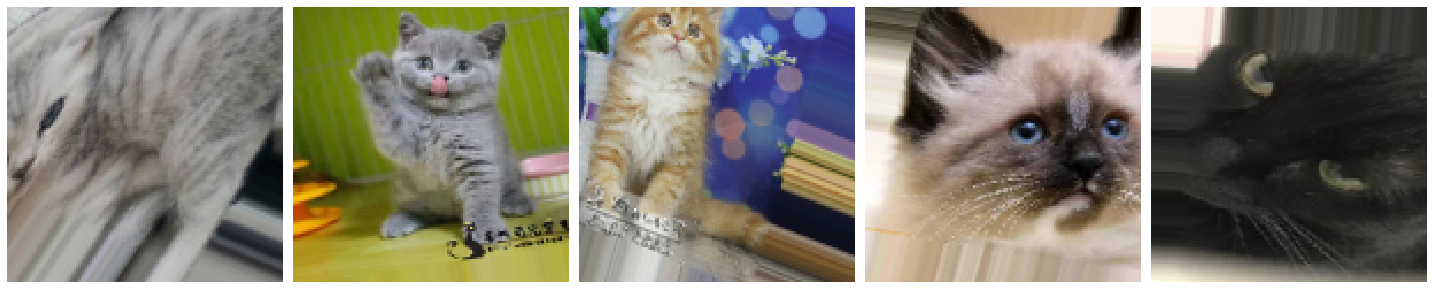

In [9]:
plotImg(sample_img_train[:15])

## Model

In [10]:
VGGNet = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    # Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    # Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    # Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(classNum, activation='softmax'),
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(classNum, activation='softmax')
])

In [12]:
# from tensorflow.keras.callbacks import LearningRateScheduler
# lr_base = 0.001
# epochs = 250
# lr_power = 0.9
# def lr_scheduler(epoch, mode='power_decay'):
#     '''if lr_dict.has_key(epoch):
#         lr = lr_dict[epoch]
#         print 'lr: %f' % lr'''
 
#     if mode is 'power_decay':
#         # original lr scheduler
#         lr = lr_base * ((1 - float(epoch) / epochs) ** lr_power)
#     if mode is 'exp_decay':
#         # exponential decay
#         lr = (float(lr_base) ** float(lr_power)) ** float(epoch + 1)
#     # adam default lr
#     if mode is 'adam':
#         lr = 0.001
 
#     if mode is 'progressive_drops':
#         # drops as progression proceeds, good for sgd
#         if epoch > 0.9 * epochs:
#             lr = 0.0001
#         elif epoch > 0.75 * epochs:
#             lr = 0.001
#         elif epoch > 0.5 * epochs:
#             lr = 0.01
#         else:
#             lr = 0.1
 
#     print('lr: %f' % lr)
#     return lr
 
# # 学习率调度器
# scheduler = LearningRateScheduler(lr_scheduler)

In [13]:
sgd = opt.SGD(lr=1e-2, decay=1e-6, momentum=0.8, nesterov=True)

In [14]:
model.compile(optimizer=sgd,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'],
             )

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 120, 120, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)            

## Train model

In [16]:
def get_available_gpus():
    """
    code from http://stackoverflow.com/questions/38559755/how-to-get-current-available-gpus-in-tensorflow
    """
    from tensorflow.python.client import device_lib as _device_lib
    local_device_protos = _device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' or x.device_type == 'CPU']

In [17]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  
get_available_gpus()

['/device:CPU:0', '/device:GPU:0']

In [18]:
with tf.device('/gpu:0'):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = total_train // batch_size,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = total_val // batch_size     
    )

Epoch 1/30
162/162 [==============================] - 112s 693ms/step - loss: 2.6731 - acc: 0.0976 - val_loss: 2.6126 - val_acc: 0.1375
Epoch 2/30
162/162 [==============================] - 110s 681ms/step - loss: 2.5498 - acc: 0.1652 - val_loss: 2.4979 - val_acc: 0.1909
Epoch 3/30
119/162 [=====================>........] - ETA: 23s - loss: 2.4736 - acc: 0.1952

KeyboardInterrupt: 

## Result visualisation 

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()